In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Change "dir" path to wherever this notebook and train.csv and test.csv are kept

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [3]:
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder

In [4]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint
from scipy.stats import norm
# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

In [5]:
dir = os.getcwd() + '/drive/My Drive/SocialMediaFakeOrReal/'

First part is to train the classifier on dataset on spam/genuine social media accounts from kaggle. Link: https://www.kaggle.com/datasets/free4ever1/instagram-fake-spammer-genuine-accounts

In [6]:
train_df = pd.read_csv(dir + 'train.csv')
test_df = pd.read_csv(dir + 'test.csv')

Notice of all the features, has profile pic, name==username, isprivate, external url are all binary rest are all continuous.

In first random forest classifer, combine all features to predict target: whether account is fake

In [7]:
X_train =train_df.drop(columns=['fake'])
y_train = train_df['fake']

In [8]:
X_test =test_df.drop(columns=['fake'])
y_test = test_df['fake']

In [9]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier()

In [10]:
y_pred = rf.predict(X_test)



In [11]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.925


Generate confusion matrix

In [12]:
confusion_matrix = confusion_matrix(y_test.to_numpy(), y_pred)


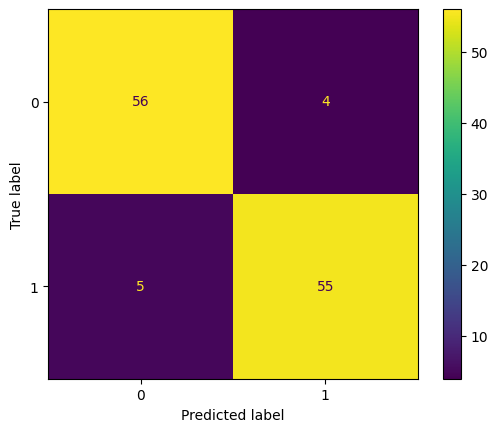

In [13]:
disp = ConfusionMatrixDisplay(confusion_matrix)
disp.plot()
plt.show()

Now run K folds cross validation 5 times

In [14]:
scores = cross_val_score(rf, X_test, y_test, cv=5)
print("Cross-validation scores:", scores)

Cross-validation scores: [1.         1.         0.95833333 0.95833333 0.95833333]


Logistic Regession

In [15]:
logreg = LogisticRegression(random_state=16)

# fit the model with data
logreg.fit(X_train, y_train)



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=16)

In [16]:
scores = cross_val_score(logreg, X_test, y_test, cv=5)
print("Cross-validation scores:", scores)

Cross-validation scores: [1.         1.         0.79166667 0.83333333 0.91666667]


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Again plot confusion matrix

Rescale all columns to be within a range of [0,1]

In [17]:
from sklearn.preprocessing import MinMaxScaler


In [18]:
X_train_binary = X_train.loc[:, ['profile pic', 'name==username', 'private', 'external URL']]
X_train_continuous = X_train.drop(['profile pic', 'name==username', 'private', 'external URL'], axis=1)
X_train_continuous[:]= MinMaxScaler().fit_transform(X_train_continuous)

X_test_binary = X_test.loc[:, ['profile pic', 'name==username', 'private', 'external URL']]
X_test_continuous = X_test.drop(['profile pic', 'name==username', 'private', 'external URL'], axis=1)
X_test_continuous[:]= MinMaxScaler().fit_transform(X_test_continuous.to_numpy())


Preserve original order of dataframe columns

In [19]:
columnOrder = X_train.columns

X_train_merged = pd.concat([X_train_continuous, X_train_binary], axis=1)
X_train_merged = X_train_merged[columnOrder]

X_test_merged = pd.concat([X_test_continuous, X_test_binary], axis=1)
X_test_merged = X_test_merged[columnOrder]

Run K folds cross validation again

In [20]:
rf.fit(X_train_merged, y_train)

RandomForestClassifier()

In [21]:
scores = cross_val_score(rf, X_test_merged, y_test, cv=5)
print("Cross-validation scores:", scores)

Cross-validation scores: [0.95833333 1.         0.91666667 0.95833333 0.95833333]


Draw heat map to analyze correlation of variables in data

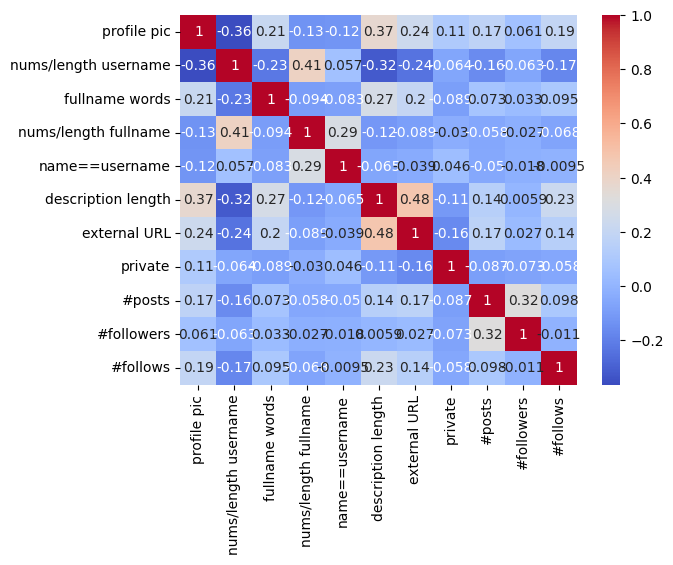

In [22]:
dataplot = sns.heatmap(X_train_merged.corr(), cmap="coolwarm", annot=True)


Convert continuous data into bins?

In [23]:
def normalBins(col, col_name):
    #use just 5 bins
    mean, std_dev = norm.fit(col)
    #cover 3 standard deviations

    # Define bin edges based on standard deviations from the mean
    bin_edges = [mean - 2 * std_dev, mean - std_dev, mean + std_dev, mean + 2 * std_dev]

    bins = np.digitize(col, bin_edges)

    labels_mapping = {1: "very low "+col_name, 2: "low "+col_name, 3: "normal "+col_name, 4: "high "+col_name, 5: "very high "+col_name}

    bins = np.vectorize(labels_mapping.get)(bins)

    return bins


In [24]:
def generateBinary(bins, col_name):
  possible_labels =["very low "+col_name, "low "+col_name, "normal "+col_name, "high "+col_name, "very high "+col_name]
  #possible_labels =["very low", "low", "normal", "high", "very high"]
  bins= pd.Categorical(bins, categories=possible_labels)
  binary_df = pd.get_dummies(bins, columns=possible_labels, dtype='int')
  return binary_df



In [25]:
print( X_train_continuous.columns)

Index(['nums/length username', 'fullname words', 'nums/length fullname',
       'description length', '#posts', '#followers', '#follows'],
      dtype='object')


In [26]:
#test on column
bins_followers = normalBins(X_train_continuous['#followers'], '#followers')
binary_followers = generateBinary(bins_followers, '#followers')

In [27]:
print(bins_followers)

['low #followers' 'low #followers' 'low #followers' 'low #followers'
 'low #followers' 'low #followers' 'low #followers' 'low #followers'
 'low #followers' 'low #followers' 'low #followers' 'low #followers'
 'low #followers' 'low #followers' 'low #followers' 'low #followers'
 'low #followers' 'low #followers' 'low #followers' 'low #followers'
 'low #followers' 'low #followers' 'low #followers' 'low #followers'
 'high #followers' 'low #followers' 'low #followers' 'low #followers'
 'low #followers' 'low #followers' 'low #followers' 'low #followers'
 'low #followers' 'low #followers' 'low #followers' 'high #followers'
 'low #followers' 'low #followers' 'low #followers' 'low #followers'
 'low #followers' 'low #followers' 'low #followers' 'low #followers'
 'high #followers' 'low #followers' 'low #followers' 'low #followers'
 'low #followers' 'low #followers' 'low #followers' 'low #followers'
 'low #followers' 'low #followers' 'low #followers' 'low #followers'
 'low #followers' 'low #followe

In [28]:
print(binary_followers.value_counts())

very low #followers  low #followers  normal #followers  high #followers  very high #followers
0                    1               0                  0                0                       571
                     0               0                  1                0                         5
Name: count, dtype: int64


Convert all of the continuous data into discrete bins

In [29]:
discretized = pd.DataFrame()

for col in X_train_continuous.columns:
  print(col)
  bin = normalBins(X_train_continuous[col], col)
  binary_df = generateBinary(bin, col)
  discretized = pd.concat([discretized, binary_df], axis=1)

nums/length username
fullname words
nums/length fullname
description length
#posts
#followers
#follows


Merge Binary with Binned data and perform apriori

In [30]:
combined = pd.concat([discretized, X_train_binary], axis=1)

In [31]:
from mlxtend.frequent_patterns import apriori, association_rules

In [32]:
#set a threshold value for the support value and calculate the support value.
frequent_itemsets= apriori(combined, min_support = 0.6, use_colnames = True, verbose = 1)
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))
frequent_itemsets

Processing 12 combinations | Sampling itemset size 6


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/mlxtend/frequent_patterns/fpcommon.py:110: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,support,itemsets,length
0,0.812500,(low nums/length username),1
1,0.815972,(low fullname words),1
2,0.909722,(low nums/length fullname),1
3,0.861111,(low description length),1
4,0.951389,(low #posts),1
...,...,...,...
107,0.614583,"(low #followers, low description length, low f...",5
108,0.605903,"(low #followers, low description length, low f...",5
109,0.649306,"(low #followers, low fullname words, low #foll...",5
110,0.666667,"(low #followers, low description length, low f...",5


Filter through generated rules

Display rules that have support greater than 90%

In [33]:
frequent_itemsets[  (frequent_itemsets['support'] >= 0.9) ]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,support,itemsets,length
2,0.909722,(low nums/length fullname),1
4,0.951389,(low #posts),1
5,0.991319,(low #followers),1
6,0.934028,(low #follows),1
22,0.901042,"(low #followers, low nums/length fullname)",2
28,0.944444,"(low #followers, low #posts)",2
31,0.927083,"(low #follows, low #followers)",2


In [34]:
frequent_itemsets[  (frequent_itemsets['support'] >= 0.8) ]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,support,itemsets,length
0,0.812500,(low nums/length username),1
1,0.815972,(low fullname words),1
2,0.909722,(low nums/length fullname),1
3,0.861111,(low description length),1
4,0.951389,(low #posts),1
5,0.991319,(low #followers),1
6,0.934028,(low #follows),1
12,0.803819,"(low #followers, low nums/length username)",2
18,0.810764,"(low fullname words, low #followers)",2
21,0.862847,"(low #posts, low nums/length fullname)",2


As you can see we only really need to know the number of followers, length of fullname, number of posts, and number of follows in the data to make meaningful predictitons based on apriori association rule generation.

In [81]:
#print out distribution of most important attributes according to apriori

fake_fullname = train_df.groupby('fullname words')['fake'].value_counts(normalize=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [89]:
fake_fullname*=100

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [90]:
print(fake_fullname)

fullname words  fake
0               0        52.631579
                1        47.368421
1               1        73.498233
                0        26.501767
2               0        78.074866
                1        21.925134
3               0        73.529412
                1        26.470588
4               0        71.428571
                1        28.571429
5               0        75.000000
                1        25.000000
6               0       100.000000
10              0       100.000000
12              0       100.000000
Name: proportion, dtype: float64


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [91]:
display(fake_fullname.to_frame())

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


proportion
fullname words fake            
0              0      52.631579
               1      47.368421
1              1      73.498233
               0      26.501767
2              0      78.074866
               1      21.925134
3              0      73.529412
               1      26.470588
4              0      71.428571
               1      28.571429
5              0      75.000000
               1      25.000000
6              0     100.000000
10             0     100.000000
12             0     100.000000

In [92]:
fake_followers = train_df.groupby('#followers')['fake'].value_counts(normalize=True)
fake_followers*=100
display(fake_followers.to_frame())

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,,proportion
#followers,fake,
0,1,100.0
1,1,100.0
2,1,100.0
3,1,100.0
4,1,100.0
...,...,...
3896490,0,100.0
5315651,0,100.0
6741307,0,100.0


In [93]:
fake_posts = train_df.groupby('#posts')['fake'].value_counts(normalize=True)
fake_posts*=100
display(fake_posts.to_frame())

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


proportion
#posts fake            
0      1      97.452229
       0       2.547771
1      1      85.714286
       0      14.285714
2      1      77.272727
...                 ...
1164   0     100.000000
1232   0     100.000000
1570   0     100.000000
4494   0     100.000000
7389   0     100.000000

[225 rows x 1 columns]

In [94]:
fake_follows = train_df.groupby('#follows')['fake'].value_counts(normalize=True)
fake_follows*=100
display(fake_follows.to_frame())

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


proportion
#follows fake            
0        1      90.909091
         0       9.090909
1        1     100.000000
2        1     100.000000
3        1      50.000000
...                   ...
4664     0     100.000000
7202     0     100.000000
7272     1     100.000000
7399     0     100.000000
7500     0     100.000000

[443 rows x 1 columns]